# Predicting Trimethoprim resistance in DHFR<sub>pj</sub>



This notebook demonstrates how ROBUST descriptors can be used to inform if a mutant variant of a protein is less succebtible to a specific drug.

This is achieved using a relatively simpel classification model. The classifiers area under the reciever operating characteristic curve was 0.75 &pm; 0.15, indicating that resistant variants show distinct differencesin in pysical interactions and dynamics. 

The notebook is sectioned into initial exploratory analysis and model training and evaluation.

## Module Imports

In [1]:
import os
import json

import numpy as np
import pandas as pd

from scipy import interp
from scipy.stats import probplot, norm

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc, confusion_matrix

Default matplotlib parameters are provided in a separate json file:

In [2]:
%matplotlib inline
with open('.rcparams.json', 'r') as fh:
    matplotlib.rcParams.update(json.load(fh))

## Load data

Let first load the data.
For this project a large number of complexes have been simulated, however we restrict initial analysis TMP/DHFR<sub>pj</sub> variants from Queener et al.

In [3]:
datadir = os.path.abspath('./data')

dataset = pd.read_csv(os.path.join(datadir, 'dataset.csv'), sep=',', index_col=0)


dG = dataset.groupby('name').agg({'dG': 'first'})

labels = dataset.groupby('name').agg({'label': 'first'})

eval_set = labels.index # The final set of structures to evaluate

n_variants = len(labels)

In [4]:
X_vdw = pd.read_csv(os.path.join(datadir, 'data_vdw_merged.csv'), sep=',', index_col=0).loc[eval_set]

X_vdw.drop(X_vdw.columns[X_vdw.mean()>-0.1], axis=1, inplace=True)

X_vdw.columns = ['vdw '+ c for c in X_vdw.columns]
#X_vdw = X_vdw.loc[eval_set]

X_hbond = pd.read_csv(os.path.join(datadir, 'data_hbond_merged.csv'), sep=',', index_col=0).loc[eval_set]

X_hbond.columns = ['hbond '+ c for c in X_hbond.columns]


X_rms = pd.read_csv(os.path.join(datadir, 'data_rms_merged.csv'), sep=',', index_col=0).loc[eval_set]

X_rms.columns = ['rms '+ c for c in X_rms.columns]

X_merged = pd.concat([X_rms, X_vdw, X_hbond], axis=1)

X = np.array(X_merged)

## Distribution of TMP binding affinity.
Lets take a look at the most important variable, the dbinding affinity of TMP against DHFR<sub>pj</sub>

In [5]:
dG.describe()

,dG
count,20.000000
mean,-9.198504
std,0.980427
min,-10.412035
25%,-9.916003
50%,-9.419213
75%,-8.840438
max,-6.617862


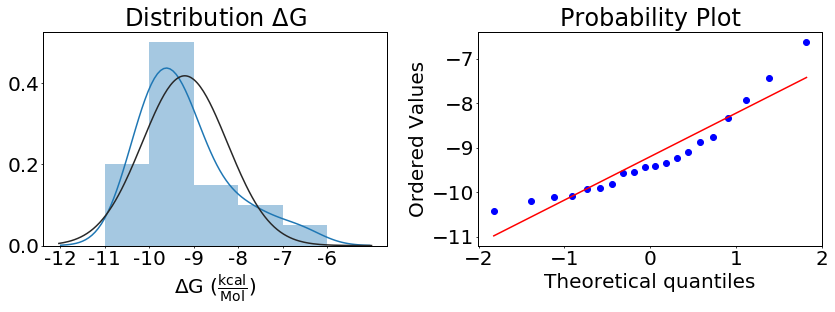

In [6]:
bins=np.arange(-12,-5, 1)
plt.figure(figsize=(12,8))

ax1 = plt.subplot(2,2,1)
plt.title('Distribution $\\rm \\Delta G$')
sns.distplot(dG , fit=norm, bins=bins,)
plt.xlabel('$\\rm \\Delta G\ (\\frac{kcal}{Mol})$')
plt.xticks(ticks=bins, labels=map(str, bins))

ax2 = plt.subplot(2,2,2)
_=probplot(np.array(dG).reshape(-1), plot=plt)
plt.tight_layout()
plt.show()

This does not bode well for regression, the dataset shows long tails and half of the binding affinities fall within a ~1 kcal/Mol window. Luckily for us the authors have also reported which variants show significant change in TMP K<sub>i</sub>.

In the dataset these structures are labeled either susceptible or resistant depending on whether TMP binding affinity is significantly different from Wildtype.

Lets take a look at the distribution of binding affinities as a function of resistance:

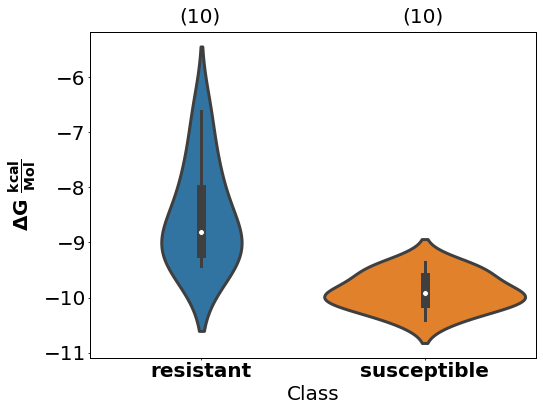

In [8]:
# digitize labels
y = np.array(labels.label=='susceptible').astype(int)

plt.figure(figsize=(8,6))
ax = sns.violinplot(x=y, y=np.array(dG).reshape(-1), linewidth=3, width=0.9)
ax.set_xlabel('Class')
ax.set_ylabel('$\\bf \\Delta G\ \\frac{kcal}{Mol}$', weight='bold')
ax.set_xticklabels(['resistant', 'susceptible'], weight='bold')
ax.text(-0.1, -5, '(10)')
ax.text(0.9, -5, '(10)')
plt.show()

With 2 equaly sized classes, classification of variants in **suscebtible** and **resistant** should be feasible.

There are a number or resistant variants with &Delta;G similar to the susceptible variants. 

These might be difficult to distinguish from the susceptible variants, however, highly resistant variants should be readily distinguishable.


## Calssifier

Our dataset consists of 20 datapoints (n) with 2487 features (p) each. Thus prior to classification we should reduce the number of features so that n &gt; p. This means we either have to select features or project them on a lower dimensional space (e. g. PCA). Although we chose the latter approach in this notebook, we also evaluated ANOVA based feature selection and regularized regression which gave similar results.


### Evaluation


To make the most of our limited data we use stratified crossvalidation, spliting the dataset into two equaly sized subsets. Each subsets are contains 5 susceptible and 5 resistant variants used once for training and once for testing. This process is repeated 50 times on random permutations of the dataset.

Note, that Standardization and PCA is performed on the trainingset and then applied to the testset.  
This is necesarry because the testset is treated as 10 "unknown" samples. If we would perform standardization and PCA prior to crossvalidation, the testset would no longer be unknown, defeating the purpose of crossvalidation.

In [40]:
n_repeats = 50
n_splits = 2

np.random.seed(666)

clf = Pipeline([('scaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('clf', LogisticRegression(max_iter=100, n_jobs=1, solver='liblinear'))])


seeds = np.random.randint(low=1, high=10000, size=n_repeats)

cv_scores = np.zeros((n_repeats, n_splits))

cmatrices = np.zeros((n_repeats, 2, 2))
predicts = np.zeros((n_repeats, n_variants))


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for i, seed in enumerate(seeds):
    sskf = StratifiedShuffleSplit(n_splits=n_splits, random_state=seed, test_size=1/n_splits)
    for train, test in sskf.split(X, y):
        clf.fit(X[train], y[train])
        
        cmatrices[i] = confusion_matrix(y[test], clf.predict(X[test]))
        predicts[i, test] = clf.predict(X[test])
        probas_ = clf.predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

Let's plot the results:

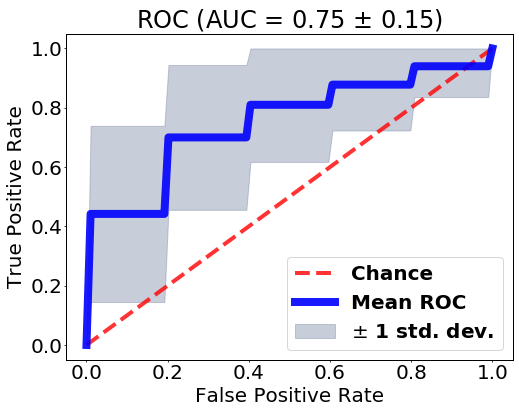

In [41]:
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

plt.figure(figsize=(8, 6))

plt.subplot()

plt.plot([0, 1], [0, 1], linestyle='--', lw=4, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC',
         lw=8, alpha=.9)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='#7582A1', alpha=.4,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (AUC = {:.2f} $\pm$ {:.2f})'.format(mean_auc, std_auc))
plt.legend(prop={'weight':'bold'}, loc='lower right')
plt.show()

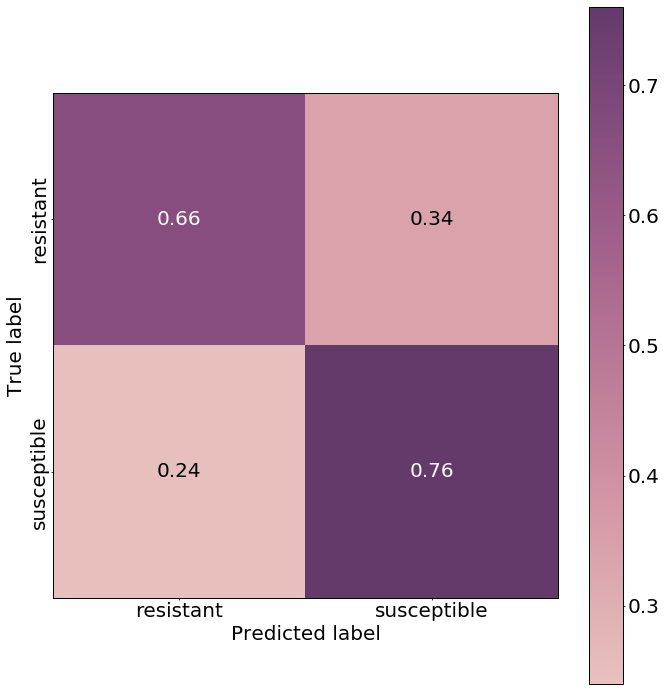

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))
cm = cmatrices.sum(axis=0)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
plt.colorbar(im)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=['resistant', 'susceptible'],
       ylabel='True label',
       xlabel='Predicted label')


ax.set_yticklabels(['resistant', 'susceptible'] ,rotation=90, horizontalalignment='right', verticalalignment='center')

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

The classifier can definitely pick up differences in dynamics and interactions between susceptible and resistant variants. It performs quiet well predicting susceptible variants, however it has a harder time distinguishing resistant variants from susceptible variants. This is likely because some resistant variants are quiet similar to susceptible variants.


Finally lets check out the principal component projection of the full dataset:

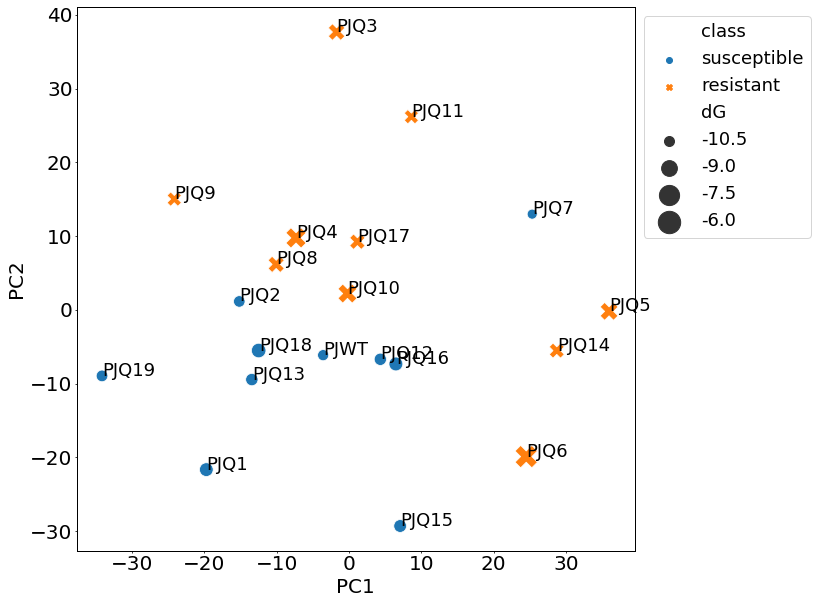

In [24]:
n_components = 2
pca = PCA(n_components=n_components, )
pc = pca.fit_transform(StandardScaler().fit_transform(X))
pc_df = pd.DataFrame(np.hstack((pc, y.reshape(-1,1), np.array(dG).reshape(-1,1))),
                     columns=['PC{}'.format(x) for x in range(1, n_components+1)]+['class', 'dG'], index=eval_set)

for index in pc_df.index:
    if pc_df.loc[index, 'class']:
        pc_df.loc[index, 'class'] = 'susceptible'
    else:
        pc_df.loc[index, 'class'] = 'resistant'

fig = plt.figure(figsize=(10,10))
ax = sns.scatterplot(x='PC1', y='PC2', style='class', hue='class', size='dG', sizes=(100, 500), data=pc_df)

def label_point(x, y, val, ax):
    a = pd.DataFrame.from_dict({'x': x, 'y': y, 'val': val})
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), fontsize=18)

label_point(pc_df['PC1'].values, pc_df['PC2'].values, np.array(pc_df.index), ax)
plt.legend(loc='upper left', fontsize=18, bbox_to_anchor=(1., 1.))
plt.show()

## Conclusion

Using molecular dynamcis and ROBUST features we were able to build a model that is able to distinguish TMP susceptible and resistant variants of DHFR<sub>pj</sub>.

This is remarkable because:

**A)** There was no prior structural information on DHFR<sub>pj</sub>

**B)** Differences in binding affinity were small.

Of the 10 variants that were distinct from wildtype, only 5 showed a decrease in binding affinity that was larger than one order of magnitude.